In [2]:
!pip install torch==2.7.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
!git clone https://github.com/facebookresearch/sam3.git
!cd sam3 && pip install -e .

Looking in indexes: https://download.pytorch.org/whl/cu126
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.8/866.8 MB 66.0 MB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 110.4 MB/s  0:00:020:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 201.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 221.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 56.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 80.1 MB/s  0:00:04m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 280.1 MB/s  0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 

In [ ]:
import torch
torch.cuda.empty_cache()

In [1]:
from sam3.model_builder import build_sam3_video_predictor
import numpy as np

# -----------------------------
# 1. Build the SAM3 predictor
# -----------------------------
video_predictor = build_sam3_video_predictor()
video_path = "Test.mp4"

# -----------------------------
# 2. Start a session
# -----------------------------
response = video_predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]

# -----------------------------
# 3. Detect all cows on frame 0
# -----------------------------
response = video_predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=0,
        text="cow"
    )
)
outputs = response["outputs"]

# -----------------------------
# 4. Select the top 3 cows
# -----------------------------
# MAX_COWS = 3
# obj_ids = outputs["out_obj_ids"]
# scores = outputs["out_probs"]

# top_indices = scores.argsort()[::-1][:MAX_COWS]
# top_obj_ids = obj_ids[top_indices]

# -----------------------------
# 6. Propagate only the selected cows
# -----------------------------
def propagate_in_video(predictor, session_id):
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]
    return outputs_per_frame

outputs_per_frame = propagate_in_video(video_predictor, session_id)

print(f"Propagation finished. Frames processed: {len(outputs_per_frame)}")


INFO 2025-12-14 16:28:35,311 36580 sam3_video_predictor.py: 299: using the following GPU IDs: [0]
INFO 2025-12-14 16:28:35,312 36580 sam3_video_predictor.py: 315: 


	*** START loading model on all ranks ***


INFO 2025-12-14 16:28:35,312 36580 sam3_video_predictor.py: 317: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2025-12-14 16:28:42,154 36580 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2025-12-14 16:28:44,983 36580 sam3_video_predictor.py: 319: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2025-12-14 16:28:44,983 36580 sam3_video_predictor.py: 330: 


	*** DONE loading model on all ranks ***


frame loading (OpenCV) [rank=0]: 100%|██████████| 202/202 [00:00<00:00, 305.90it/s]


propagate_in_video:   0%|          | 0/202 [00:00<?, ?it/s]

propagate_in_video: 0it [00:00, ?it/s]

Propagation finished. Frames processed: 202


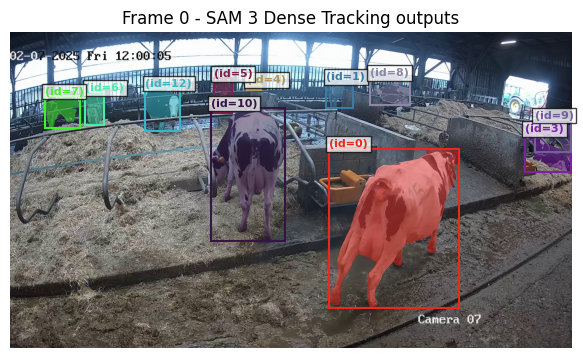

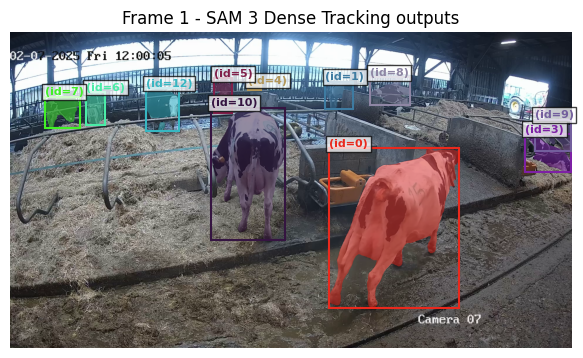

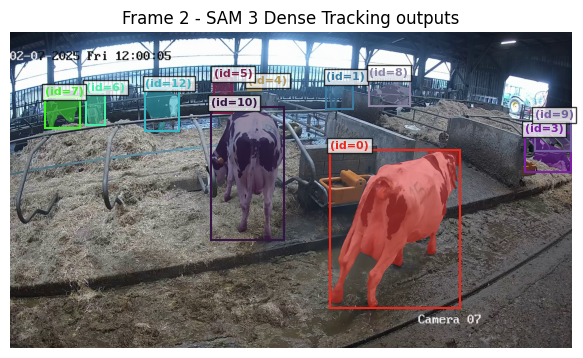

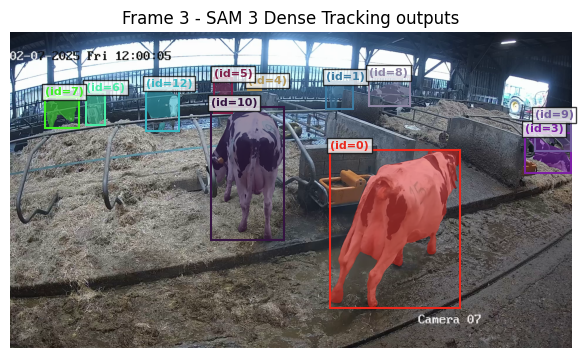

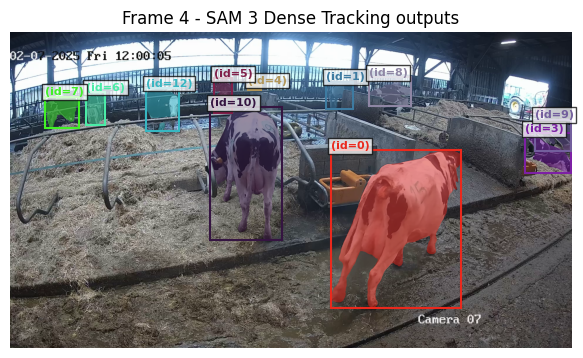

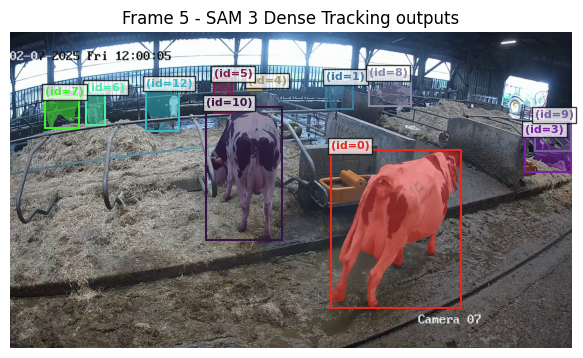

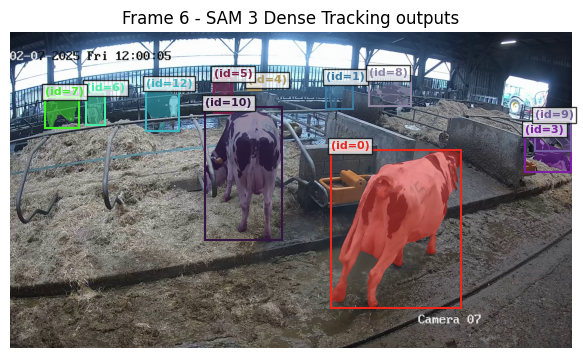

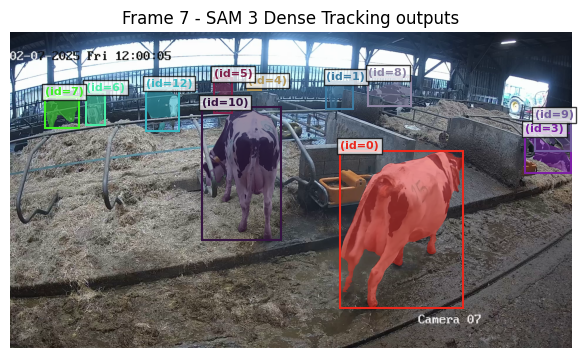

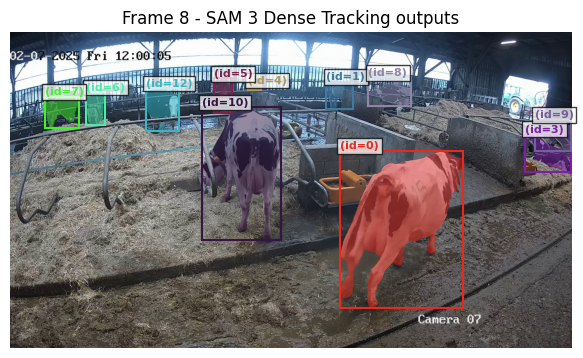

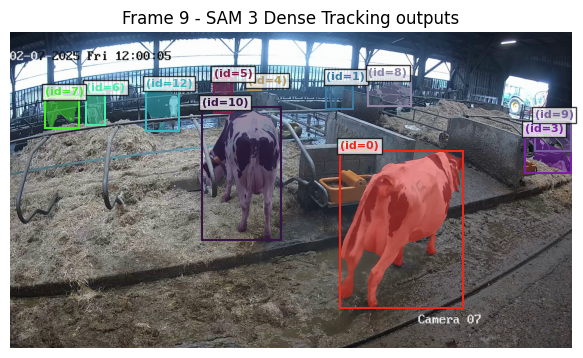

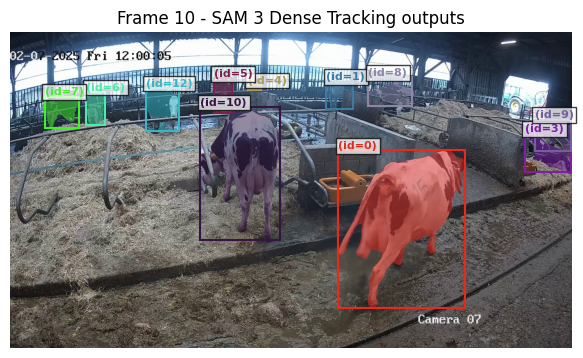

KeyboardInterrupt: 

In [2]:
# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
import matplotlib.pyplot as plt
from sam3.visualization_utils import (
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
)

outputs_per_frame_prep = prepare_masks_for_visualization(outputs_per_frame)

import cv2

cap = cv2.VideoCapture(video_path)
video_frames_for_vis = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    video_frames_for_vis.append(frame_rgb)

cap.release()



vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame_prep)):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame_prep],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )


Extraction of the bounding boxes (the padding is composed of pixels from the video)

In [6]:
import numpy as np
import cv2

# -----------------------------
# 1. Pick cow ID to follow
# -----------------------------
cow_obj_id = 0  # choose one of the keys from frame 0

# -----------------------------
# 2. Helper: mask → bbox
# -----------------------------
def mask_to_bbox(mask):
    ys, xs = np.where(mask)
    if len(xs) == 0 or len(ys) == 0:
        return None
    return int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max())

# -----------------------------
# 3. Extract cow bbox per frame
# -----------------------------
cow_bboxes = {}
for frame_idx, frame_masks in outputs_per_frame_prep.items():  # frame_masks is dict of obj_id → mask
    mask = frame_masks.get(cow_obj_id)
    if mask is None:
        cow_bboxes[frame_idx] = None
        continue
    cow_bboxes[frame_idx] = mask_to_bbox(mask)

# -----------------------------
# 4. Determine stable crop size
# -----------------------------
PADDING = 10
valid_boxes = [b for b in cow_bboxes.values() if b is not None]
max_w = max(b[2] - b[0] for b in valid_boxes) + 2 * PADDING
max_h = max(b[3] - b[1] for b in valid_boxes) + 2 * PADDING

# -----------------------------
# 5. Crop helper
# -----------------------------
def crop_around_bbox(frame, bbox, crop_w, crop_h):
    x1, y1, x2, y2 = bbox
    cx = (x1 + x2) // 2
    cy = (y1 + y2) // 2
    h, w, _ = frame.shape

    x1 = max(0, cx - crop_w // 2)
    y1 = max(0, cy - crop_h // 2)
    x2 = min(w, x1 + crop_w)
    y2 = min(h, y1 + crop_h)
    return frame[y1:y2, x1:x2]

# -----------------------------
# 6. Write cropped video
# -----------------------------
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter(
    "cow_track.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (max_w, max_h),
)

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    bbox = cow_bboxes.get(frame_idx)
    if bbox is not None:
        crop = crop_around_bbox(frame, bbox, max_w, max_h)
        if crop.shape[0] == max_h and crop.shape[1] == max_w:
            out.write(crop)

    frame_idx += 1

cap.release()
out.release()
print("Done! Video saved as cow_track.mp4")


Done! Video saved as cow_track.mp4


Extraction of the bounding boxes (the padding is composed of black pixels). Doesn't work completely for now 

In [8]:
import numpy as np
import cv2

# -----------------------------
# 1. Pick cow ID to follow
# -----------------------------
cow_obj_id = 7  # choose one of the keys from frame 0

# -----------------------------
# 2. Helper: mask → bbox
# -----------------------------
def mask_to_bbox(mask):
    ys, xs = np.where(mask)
    if len(xs) == 0 or len(ys) == 0:
        return None
    return int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max())

# -----------------------------
# 3. Extract cow bbox per frame
# -----------------------------
cow_bboxes = {}
for frame_idx, frame_masks in outputs_per_frame_prep.items():  # frame_masks is dict of obj_id → mask
    mask = frame_masks.get(cow_obj_id)
    if mask is None:
        cow_bboxes[frame_idx] = None
        continue
    cow_bboxes[frame_idx] = mask_to_bbox(mask)

# -----------------------------
# 4. Determine stable crop size
# -----------------------------
PADDING = 10
valid_boxes = [b for b in cow_bboxes.values() if b is not None]
max_w = max(b[2] - b[0] for b in valid_boxes) + 2 * PADDING
max_h = max(b[3] - b[1] for b in valid_boxes) + 2 * PADDING

# -----------------------------
# 5. Crop helper with black padding
# -----------------------------
def crop_around_bbox_black(frame, bbox, crop_w, crop_h):
    x1, y1, x2, y2 = bbox
    cx = (x1 + x2) // 2
    cy = (y1 + y2) // 2
    h, w, _ = frame.shape

    # coordinates for the crop
    crop_x1 = max(0, cx - crop_w // 2)
    crop_y1 = max(0, cy - crop_h // 2)
    crop_x2 = min(w, crop_x1 + crop_w)
    crop_y2 = min(h, crop_y1 + crop_h)

    cropped_part = frame[crop_y1:crop_y2, crop_x1:crop_x2]

    # create black canvas and paste the cropped part
    black_crop = np.zeros((crop_h, crop_w, 3), dtype=np.uint8)
    h_c, w_c, _ = cropped_part.shape
    black_crop[0:h_c, 0:w_c] = cropped_part

    return black_crop

# -----------------------------
# 6. Write cropped video with black padding
# -----------------------------
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter(
    "cow_track_blackpad.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (max_w, max_h),
)

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    bbox = cow_bboxes.get(frame_idx)
    if bbox is not None:
        crop = crop_around_bbox_black(frame, bbox, max_w, max_h)
    else:
        # cow missing → black frame
        crop = np.zeros((max_h, max_w, 3), dtype=np.uint8)

    out.write(crop)
    frame_idx += 1

cap.release()
out.release()
print("Done! Video saved as cow_track_blackpad.mp4")


Done! Video saved as cow_track_blackpad.mp4


In [15]:
import numpy as np
import cv2

# -----------------------------
# 1. Pick cow ID to follow
# -----------------------------
cow_obj_id = 0  # choose one of the keys from frame 0

# -----------------------------
# 2. Helper: mask → bbox
# -----------------------------
def mask_to_bbox(mask):
    ys, xs = np.where(mask)
    if len(xs) == 0 or len(ys) == 0:
        return None
    return int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max())

# -----------------------------
# 3. Extract cow bbox per frame
# -----------------------------
cow_bboxes = {}
for frame_idx, frame_masks in outputs_per_frame_prep.items():  # frame_masks is dict of obj_id → mask
    mask = frame_masks.get(cow_obj_id)
    if mask is None:
        cow_bboxes[frame_idx] = None
        continue
    cow_bboxes[frame_idx] = mask_to_bbox(mask)

# -----------------------------
# 4. Determine fixed crop size
# -----------------------------
PADDING = 300  # black padding around cow
valid_boxes = [b for b in cow_bboxes.values() if b is not None]

# maximum bbox dimensions across all frames
max_bbox_w = max(b[2] - b[0] for b in valid_boxes)
max_bbox_h = max(b[3] - b[1] for b in valid_boxes)

# fixed crop size for the video
crop_w = max_bbox_w + 2 * PADDING
crop_h = max_bbox_h + 2 * PADDING

# -----------------------------
# 5. Crop helper with black padding
# -----------------------------
def crop_around_bbox_black(frame, bbox, crop_w, crop_h):
    # create black canvas
    black_crop = np.zeros((crop_h, crop_w, 3), dtype=np.uint8)
    
    if bbox is None:
        return black_crop  # completely black if cow missing

    h, w, _ = frame.shape
    x1, y1, x2, y2 = bbox
    cx = (x1 + x2) // 2
    cy = (y1 + y2) // 2

    # calculate where to take pixels from the original frame
    crop_x1 = max(0, cx - crop_w // 2)
    crop_y1 = max(0, cy - crop_h // 2)
    crop_x2 = min(w, crop_x1 + crop_w)
    crop_y2 = min(h, crop_y1 + crop_h)

    cropped_part = frame[crop_y1:crop_y2, crop_x1:crop_x2]

    # calculate where to paste cropped part on black canvas
    h_c, w_c, _ = cropped_part.shape
    black_crop[0:h_c, 0:w_c] = cropped_part

    return black_crop

# -----------------------------
# 6. Write video with fixed size and black padding
# -----------------------------
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter(
    "cow_track_black_fixedsize.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (crop_w, crop_h),
)

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    bbox = cow_bboxes.get(frame_idx)
    crop = crop_around_bbox_black(frame, bbox, crop_w, crop_h)
    out.write(crop)

    frame_idx += 1

cap.release()
out.release()
print("Done! Video saved as cow_track_black_fixedsize.mp4")


Done! Video saved as cow_track_black_fixedsize.mp4
